# Noise Schedule Statistical Analysis

이 노트북은 각 노이즈 스케줄러에 대해 대량 데이터셋의 forward diffusion 통계적 분석을 수행합니다.

## 🎯 목표
- Linear, Cosine, Quadratic, Sigmoid 스케줄러별 대량 데이터 분석
- 배치 단위 통계 (mean, std, percentiles)
- Gaussian 수렴 테스트
- 채널별 분석 (charge, time)
- SNR 분석 (Signal-to-Noise Ratio)
- 스케줄러별 성능 비교


## 1. 환경 설정 및 라이브러리 임포트


In [1]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Git repository 루트 찾기
def get_git_root():
    try:
        result = subprocess.run(['git', 'rev-parse', '--show-toplevel'], 
                              capture_output=True, text=True, check=True)
        return result.stdout.strip()
    except subprocess.CalledProcessError:
        return str(Path.cwd().parent)

git_root = get_git_root()
project_root = Path(git_root)
sys.path.insert(0, str(project_root))

print(f"🔧 Git repository 루트: {git_root}")
print(f"📁 프로젝트 루트: {project_root}")

# GENESIS 유틸리티 임포트
from config import load_config_from_file
from dataloader.pmt_dataloader import make_dataloader
from diffusion.noise_schedules import (
    linear_beta_schedule,
    cosine_beta_schedule,
    quadratic_beta_schedule,
    sigmoid_beta_schedule,
    compute_alpha_schedule
)

# 설정
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
print("✅ 라이브러리 임포트 완료!")


🔧 Git repository 루트: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS
📁 프로젝트 루트: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS
✅ 라이브러리 임포트 완료!


## 2. 노이즈 스케줄러 설정 및 대량 데이터 준비


In [2]:
# 테스트 파라미터
timesteps = 1000
beta_start = 1e-4
beta_end = 2e-2
cosine_s = 0.008

# 각 스케줄러별 Beta 값 생성
schedules = {
    'Linear': linear_beta_schedule(timesteps, beta_start, beta_end),
    'Cosine': cosine_beta_schedule(timesteps, cosine_s),
    'Quadratic': quadratic_beta_schedule(timesteps, beta_start, beta_end),
    'Sigmoid': sigmoid_beta_schedule(timesteps, beta_start, beta_end)
}

# Alpha 값들 계산
alpha_schedules = {}
for name, betas in schedules.items():
    alpha_schedules[name] = compute_alpha_schedule(betas)
    print(f"✅ {name} 스케줄러 Alpha 값 계산 완료")

# 데이터 로드
config = load_config_from_file(str(project_root / 'configs' / 'default.yaml'))
h5_path = str(project_root / config.data.h5_path)
print(f"\n📁 H5 파일 경로: {h5_path}")

# 대량 데이터를 위한 데이터 로더
batch_size = 64
num_batches = 50  # 총 3200개 이벤트 분석

dataloader = make_dataloader(
    h5_path,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    replace_time_inf_with=config.data.replace_time_inf_with,
    channel_first=config.data.channel_first
)

print(f"📊 분석 설정:")
print(f"  - 배치 크기: {batch_size}")
print(f"  - 분석 배치 수: {num_batches}")
print(f"  - 총 이벤트 수: {batch_size * num_batches}")
print(f"  - 분석할 스케줄러: {list(schedules.keys())}")


✅ Linear 스케줄러 Alpha 값 계산 완료
✅ Cosine 스케줄러 Alpha 값 계산 완료
✅ Quadratic 스케줄러 Alpha 값 계산 완료
✅ Sigmoid 스케줄러 Alpha 값 계산 완료

📁 H5 파일 경로: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS/GENESIS-data/22644_0921_time_shift.h5
📊 분석 설정:
  - 배치 크기: 64
  - 분석 배치 수: 50
  - 총 이벤트 수: 3200
  - 분석할 스케줄러: ['Linear', 'Cosine', 'Quadratic', 'Sigmoid']


## 3. Forward Diffusion 통계 분석 함수 정의


In [3]:
def apply_forward_diffusion_batch(x_batch, timestep, alphas_dict):
    """Apply forward diffusion to a batch of signals."""
    sqrt_alphas_cumprod_t = alphas_dict['sqrt_alphas_cumprod'][timestep]
    sqrt_one_minus_alphas_cumprod_t = alphas_dict['sqrt_one_minus_alphas_cumprod'][timestep]
    
    # Generate noise
    noise = torch.randn_like(x_batch)
    
    # Forward diffusion: x_t = sqrt(ᾱ_t) * x_0 + sqrt(1-ᾱ_t) * ε
    noisy_x = sqrt_alphas_cumprod_t * x_batch + sqrt_one_minus_alphas_cumprod_t * noise
    
    return noisy_x, noise

def compute_batch_statistics(signals, channel_idx=None):
    """Compute comprehensive statistics for a batch of signals."""
    if channel_idx is not None:
        signals = signals[:, channel_idx]
    
    # Basic statistics
    mean = torch.mean(signals)
    std = torch.std(signals)
    min_val = torch.min(signals)
    max_val = torch.max(signals)
    
    # Percentiles
    percentiles = torch.quantile(signals, torch.tensor([0.1, 0.25, 0.5, 0.75, 0.9]))
    
    return {
        'mean': mean.item(),
        'std': std.item(),
        'min': min_val.item(),
        'max': max_val.item(),
        'p10': percentiles[0].item(),
        'p25': percentiles[1].item(),
        'p50': percentiles[2].item(),
        'p75': percentiles[3].item(),
        'p90': percentiles[4].item()
    }

def gaussian_test(signals, channel_idx=None):
    """Test if signals follow Gaussian distribution."""
    if channel_idx is not None:
        signals = signals[:, channel_idx]
    
    # Convert to numpy for scipy
    signals_np = signals.cpu().numpy().flatten()
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = stats.kstest(signals_np, 'norm', 
                                     args=(np.mean(signals_np), np.std(signals_np)))
    
    # Shapiro-Wilk test (for smaller samples)
    if len(signals_np) <= 5000:
        sw_stat, sw_pvalue = stats.shapiro(signals_np)
    else:
        # For large samples, use a subset
        subset = np.random.choice(signals_np, 5000, replace=False)
        sw_stat, sw_pvalue = stats.shapiro(subset)
    
    return {
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'ks_is_gaussian': ks_pvalue > 0.05,
        'sw_statistic': sw_stat,
        'sw_pvalue': sw_pvalue,
        'sw_is_gaussian': sw_pvalue > 0.05
    }

def compute_snr(signals_original, signals_noisy, channel_idx=None):
    """Compute Signal-to-Noise Ratio."""
    if channel_idx is not None:
        signals_original = signals_original[:, channel_idx]
        signals_noisy = signals_noisy[:, channel_idx]
    
    # Signal power
    signal_power = torch.mean(signals_original ** 2)
    
    # Noise power (estimated from difference)
    noise = signals_noisy - signals_original
    noise_power = torch.mean(noise ** 2)
    
    # SNR in dB
    snr_db = 10 * torch.log10(signal_power / (noise_power + 1e-8))
    
    return snr_db.item()

print("✅ 통계 분석 함수 정의 완료!")


✅ 통계 분석 함수 정의 완료!


## 4. 대량 데이터 수집 및 각 스케줄러별 Forward Diffusion 통계 분석


In [4]:
# 대량 데이터 수집
print("📦 대량 데이터 수집 중...")
all_signals = []

for i, (x_sig_batch, _, _, _) in enumerate(dataloader):
    if i >= num_batches:
        break
    
    all_signals.append(x_sig_batch)
    
    if (i + 1) % 10 == 0:
        print(f"  📦 {i + 1}/{num_batches} 배치 수집 완료")

# 모든 데이터 결합
all_signals = torch.cat(all_signals, dim=0)

print(f"\n✅ 데이터 수집 완료!")
print(f"📊 총 {all_signals.shape[0]}개 이벤트")
print(f"📐 신호 shape: {all_signals.shape}")

# 원본 데이터 통계
original_charge_stats = compute_batch_statistics(all_signals, channel_idx=0)
original_time_stats = compute_batch_statistics(all_signals, channel_idx=1)

print(f"\n📊 원본 데이터 통계:")
print(f"  Charge - Mean: {original_charge_stats['mean']:.4f}, Std: {original_charge_stats['std']:.4f}")
print(f"  Time   - Mean: {original_time_stats['mean']:.4f}, Std: {original_time_stats['std']:.4f}")

# 분석할 timestep들
analysis_timesteps = [0, 100, 250, 500, 750, 999]
print(f"\n🎯 분석 timesteps: {analysis_timesteps}")

# 각 스케줄러별 결과 저장
scheduler_analysis_results = {}

for scheduler_name, alphas in alpha_schedules.items():
    print(f"\n🔄 {scheduler_name.upper()} 스케줄러 분석 중...")
    
    scheduler_results = {}
    
    for t in analysis_timesteps:
        print(f"  📊 Timestep {t} 분석 중...")
        
        # 배치별로 forward diffusion 적용
        noisy_signals = []
        batch_processing_size = 32  # 메모리 효율성을 위한 배치 크기
        
        for i in range(0, all_signals.shape[0], batch_processing_size):
            batch = all_signals[i:i+batch_processing_size]
            noisy_batch, noise_batch = apply_forward_diffusion_batch(batch, t, alphas)
            noisy_signals.append(noisy_batch)
        
        # 모든 배치 결합
        all_noisy = torch.cat(noisy_signals, dim=0)
        
        # 통계 계산
        charge_stats = compute_batch_statistics(all_noisy, channel_idx=0)
        time_stats = compute_batch_statistics(all_noisy, channel_idx=1)
        
        # Gaussian 테스트
        charge_gaussian = gaussian_test(all_noisy, channel_idx=0)
        time_gaussian = gaussian_test(all_noisy, channel_idx=1)
        
        # SNR 계산
        charge_snr = compute_snr(all_signals, all_noisy, channel_idx=0)
        time_snr = compute_snr(all_signals, all_noisy, channel_idx=1)
        
        # 결과 저장
        scheduler_results[t] = {
            'charge_stats': charge_stats,
            'time_stats': time_stats,
            'charge_gaussian': charge_gaussian,
            'time_gaussian': time_gaussian,
            'charge_snr': charge_snr,
            'time_snr': time_snr,
            'num_events': all_noisy.shape[0]
        }
        
        print(f"    ✅ Timestep {t} 완료 - {all_noisy.shape[0]}개 이벤트")
    
    scheduler_analysis_results[scheduler_name] = scheduler_results
    print(f"✅ {scheduler_name.upper()} 분석 완료!")

print(f"\n🎉 모든 스케줄러 통계 분석 완료!")


📦 대량 데이터 수집 중...
  📦 10/50 배치 수집 완료
  📦 20/50 배치 수집 완료
  📦 30/50 배치 수집 완료
  📦 40/50 배치 수집 완료
  📦 50/50 배치 수집 완료

✅ 데이터 수집 완료!
📊 총 3200개 이벤트
📐 신호 shape: torch.Size([3200, 2, 5160])

📊 원본 데이터 통계:
  Charge - Mean: 0.6859, Std: 6.3287
  Time   - Mean: 0.3513, Std: 1.5962

🎯 분석 timesteps: [0, 100, 250, 500, 750, 999]

🔄 LINEAR 스케줄러 분석 중...
  📊 Timestep 0 분석 중...
    ✅ Timestep 0 완료 - 3200개 이벤트
  📊 Timestep 100 분석 중...
    ✅ Timestep 100 완료 - 3200개 이벤트
  📊 Timestep 250 분석 중...
    ✅ Timestep 250 완료 - 3200개 이벤트
  📊 Timestep 500 분석 중...
    ✅ Timestep 500 완료 - 3200개 이벤트
  📊 Timestep 750 분석 중...
    ✅ Timestep 750 완료 - 3200개 이벤트
  📊 Timestep 999 분석 중...
    ✅ Timestep 999 완료 - 3200개 이벤트
✅ LINEAR 분석 완료!

🔄 COSINE 스케줄러 분석 중...
  📊 Timestep 0 분석 중...
    ✅ Timestep 0 완료 - 3200개 이벤트
  📊 Timestep 100 분석 중...
    ✅ Timestep 100 완료 - 3200개 이벤트
  📊 Timestep 250 분석 중...
    ✅ Timestep 250 완료 - 3200개 이벤트
  📊 Timestep 500 분석 중...
    ✅ Timestep 500 완료 - 3200개 이벤트
  📊 Timestep 750 분석 중...
    ✅ Timestep 75

## 5. 통계 결과 시각화 및 상세 분석


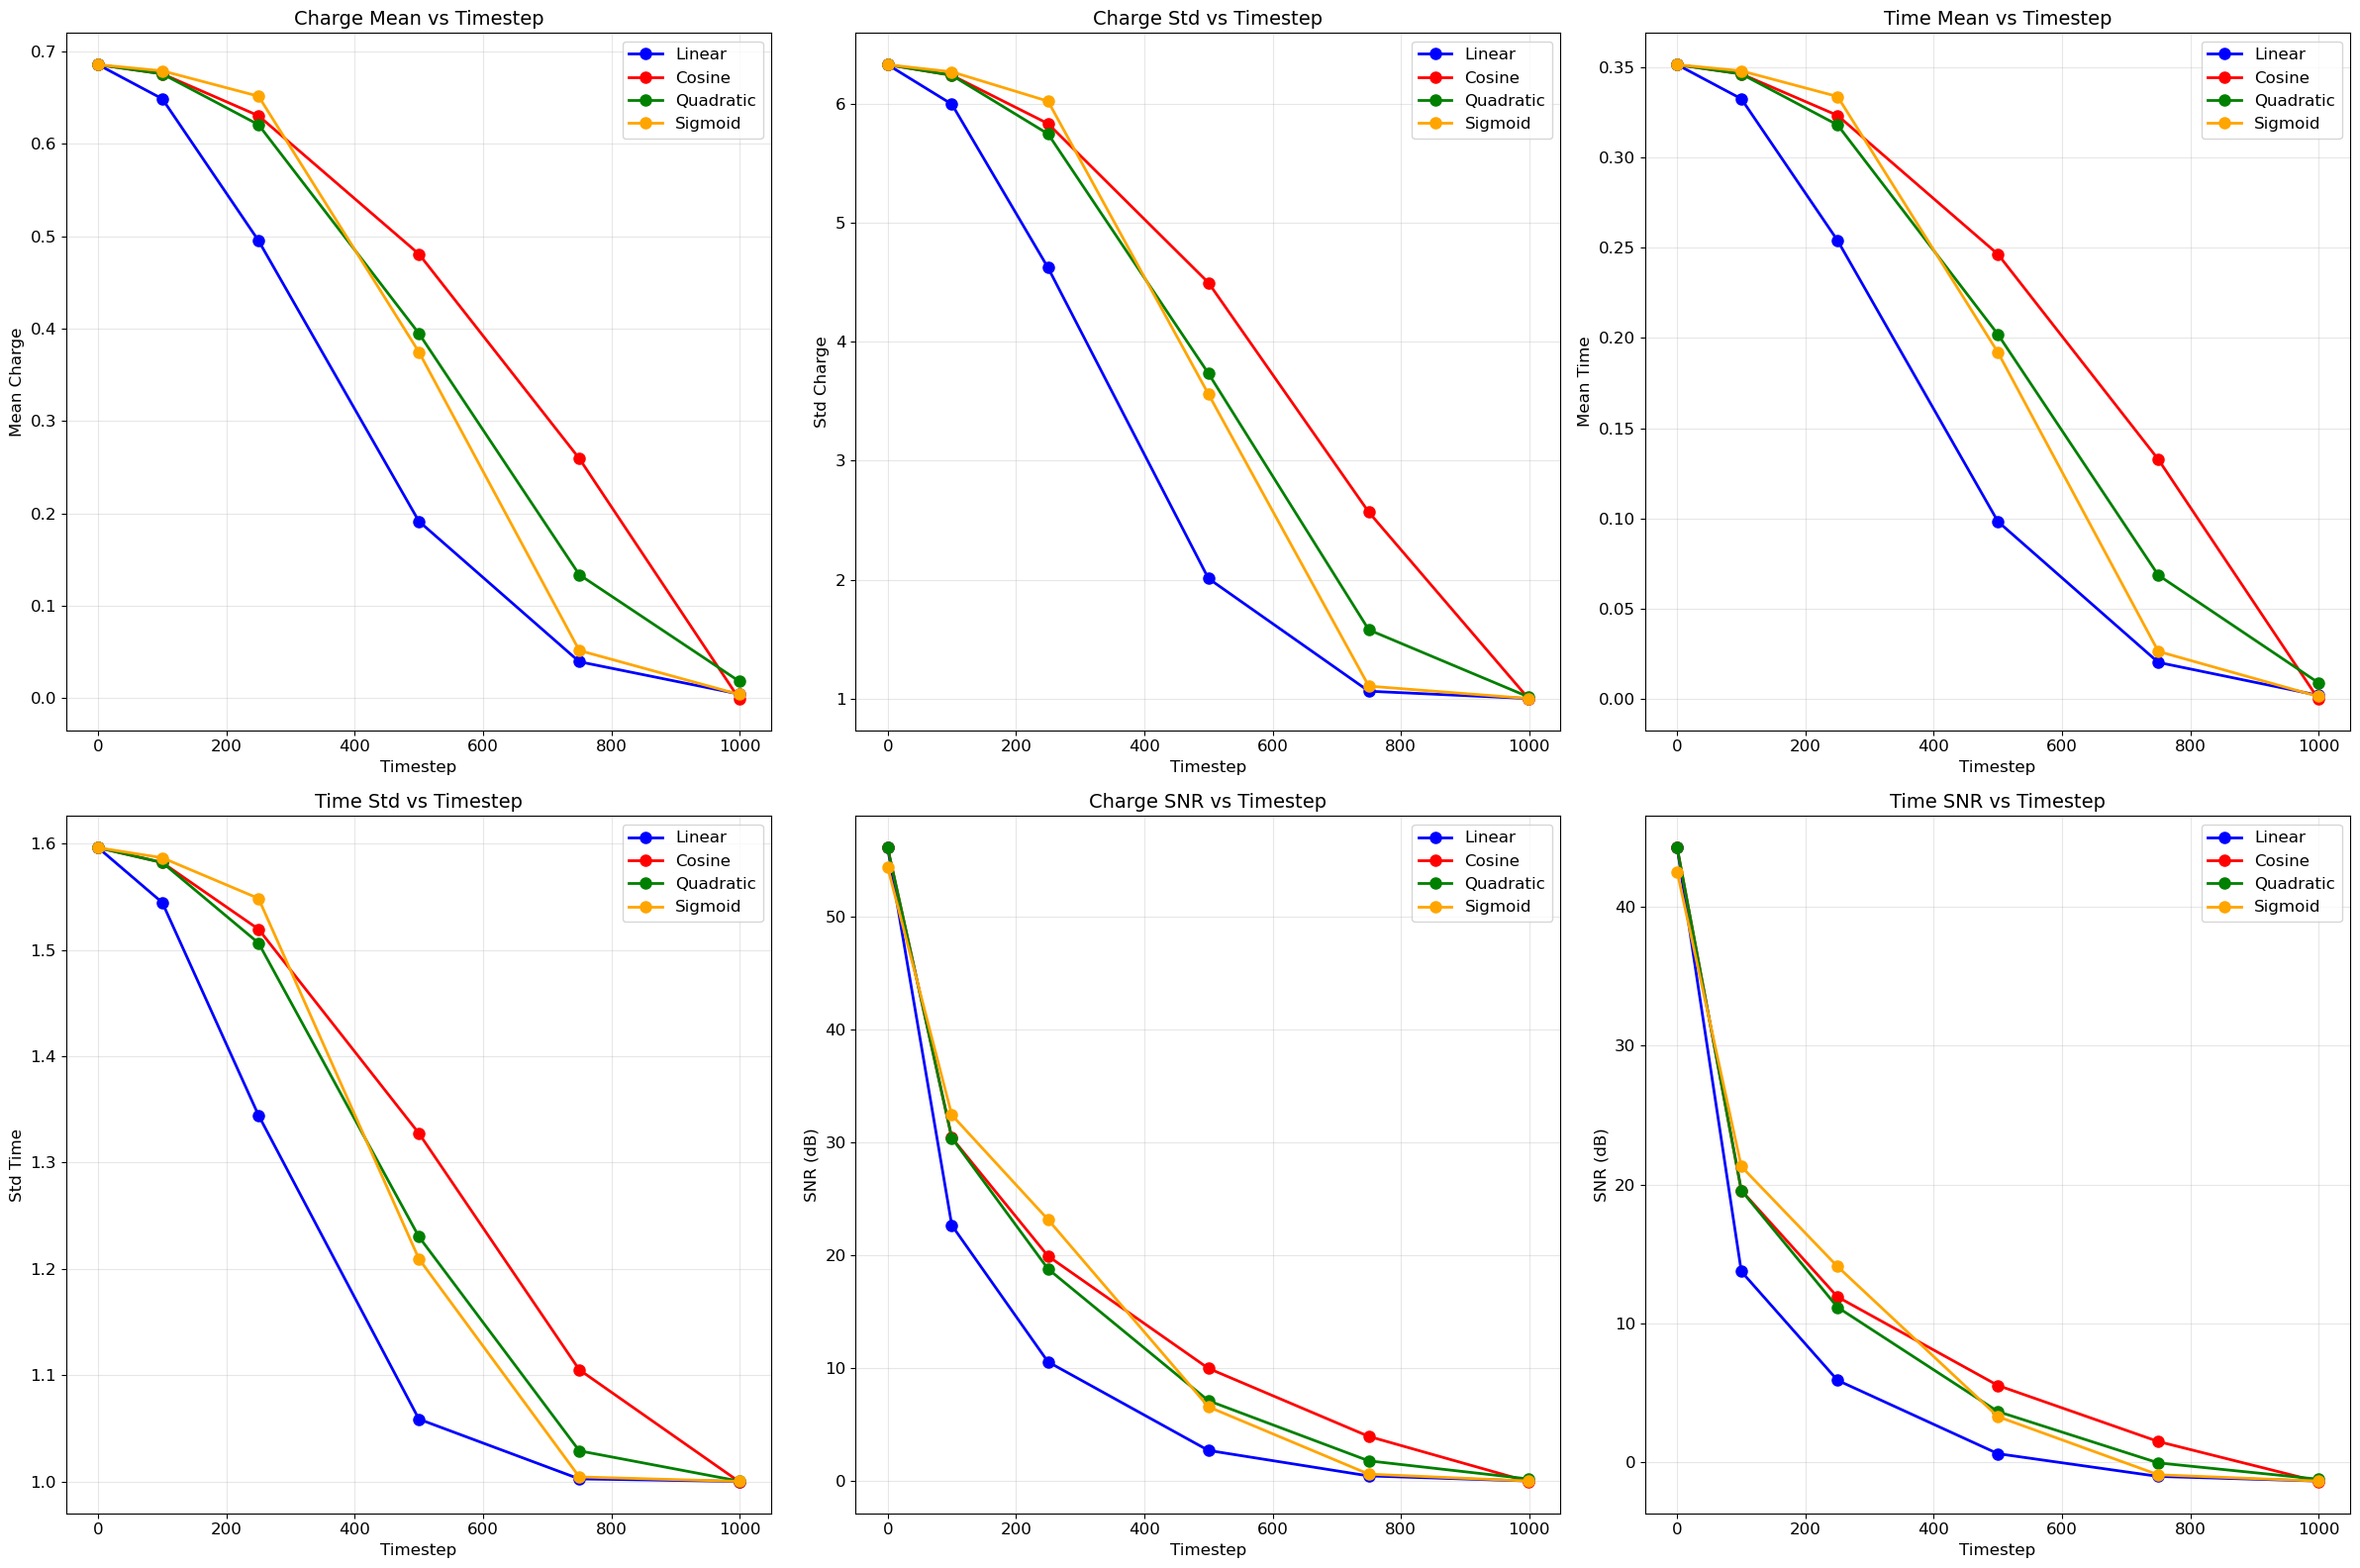

✅ 통계 분석 시각화 완료!

📊 NOISE SCHEDULE STATISTICAL ANALYSIS RESULTS

🎯 분석 요약:
  - 총 이벤트 수: 3,200
  - 분석 timesteps: [0, 100, 250, 500, 750, 999]
  - 스케줄러 수: 4

🔸 LINEAR SCHEDULE:
------------------------------------------------------------

  📊 Timestep 0:
    Charge - Mean: 0.6858, Std: 6.3284
             Range: [-0.0542, 200.9869]
    Time   - Mean: 0.3513, Std: 1.5961
             Range: [-0.0513, 9.7154]
    SNR    - Charge: 56.07 dB, Time: 44.26 dB
    Gaussian - Charge KS: ❌, SW: ❌
               Time KS: ❌, SW: ❌

  📊 Timestep 100:
    Charge - Mean: 0.6489, Std: 5.9965
             Range: [-1.6782, 190.2614]
    Time   - Mean: 0.3324, Std: 1.5445
             Range: [-1.8027, 9.9986]
    SNR    - Charge: 22.60 dB, Time: 13.75 dB
    Gaussian - Charge KS: ❌, SW: ❌
               Time KS: ❌, SW: ❌

  📊 Timestep 250:
    Charge - Mean: 0.4953, Std: 4.6217
             Range: [-3.5231, 145.4648]
    Time   - Mean: 0.2540, Std: 1.3444
             Range: [-3.8722, 9.2571]
    SNR    - Ch

In [5]:
# 통계 결과 시각화
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

colors = ['blue', 'red', 'green', 'orange']
timestep_range = analysis_timesteps

# Charge Mean
ax = axes[0, 0]
for i, (scheduler_name, results) in enumerate(scheduler_analysis_results.items()):
    means = [results[t]['charge_stats']['mean'] for t in timestep_range]
    ax.plot(timestep_range, means, 'o-', label=scheduler_name, 
           color=colors[i], linewidth=2, markersize=8)
ax.set_title('Charge Mean vs Timestep', fontsize=14)
ax.set_xlabel('Timestep')
ax.set_ylabel('Mean Charge')
ax.legend()
ax.grid(True, alpha=0.3)

# Charge Std
ax = axes[0, 1]
for i, (scheduler_name, results) in enumerate(scheduler_analysis_results.items()):
    stds = [results[t]['charge_stats']['std'] for t in timestep_range]
    ax.plot(timestep_range, stds, 'o-', label=scheduler_name, 
           color=colors[i], linewidth=2, markersize=8)
ax.set_title('Charge Std vs Timestep', fontsize=14)
ax.set_xlabel('Timestep')
ax.set_ylabel('Std Charge')
ax.legend()
ax.grid(True, alpha=0.3)

# Time Mean
ax = axes[0, 2]
for i, (scheduler_name, results) in enumerate(scheduler_analysis_results.items()):
    means = [results[t]['time_stats']['mean'] for t in timestep_range]
    ax.plot(timestep_range, means, 'o-', label=scheduler_name, 
           color=colors[i], linewidth=2, markersize=8)
ax.set_title('Time Mean vs Timestep', fontsize=14)
ax.set_xlabel('Timestep')
ax.set_ylabel('Mean Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Time Std
ax = axes[1, 0]
for i, (scheduler_name, results) in enumerate(scheduler_analysis_results.items()):
    stds = [results[t]['time_stats']['std'] for t in timestep_range]
    ax.plot(timestep_range, stds, 'o-', label=scheduler_name, 
           color=colors[i], linewidth=2, markersize=8)
ax.set_title('Time Std vs Timestep', fontsize=14)
ax.set_xlabel('Timestep')
ax.set_ylabel('Std Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Charge SNR
ax = axes[1, 1]
for i, (scheduler_name, results) in enumerate(scheduler_analysis_results.items()):
    snrs = [results[t]['charge_snr'] for t in timestep_range]
    ax.plot(timestep_range, snrs, 'o-', label=scheduler_name, 
           color=colors[i], linewidth=2, markersize=8)
ax.set_title('Charge SNR vs Timestep', fontsize=14)
ax.set_xlabel('Timestep')
ax.set_ylabel('SNR (dB)')
ax.legend()
ax.grid(True, alpha=0.3)

# Time SNR
ax = axes[1, 2]
for i, (scheduler_name, results) in enumerate(scheduler_analysis_results.items()):
    snrs = [results[t]['time_snr'] for t in timestep_range]
    ax.plot(timestep_range, snrs, 'o-', label=scheduler_name, 
           color=colors[i], linewidth=2, markersize=8)
ax.set_title('Time SNR vs Timestep', fontsize=14)
ax.set_xlabel('Timestep')
ax.set_ylabel('SNR (dB)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(project_root / 'testing' / 'noise_schedule_stat_analysis.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ 통계 분석 시각화 완료!")

# 상세 결과 요약
print("\n" + "="*100)
print("📊 NOISE SCHEDULE STATISTICAL ANALYSIS RESULTS")
print("="*100)

print(f"\n🎯 분석 요약:")
print(f"  - 총 이벤트 수: {all_signals.shape[0]:,}")
print(f"  - 분석 timesteps: {analysis_timesteps}")
print(f"  - 스케줄러 수: {len(scheduler_analysis_results)}")

for scheduler_name, results in scheduler_analysis_results.items():
    print(f"\n🔸 {scheduler_name.upper()} SCHEDULE:")
    print("-" * 60)
    
    for t in analysis_timesteps:
        result = results[t]
        print(f"\n  📊 Timestep {t}:")
        
        # Charge 통계
        charge_stats = result['charge_stats']
        print(f"    Charge - Mean: {charge_stats['mean']:.4f}, Std: {charge_stats['std']:.4f}")
        print(f"             Range: [{charge_stats['min']:.4f}, {charge_stats['max']:.4f}]")
        
        # Time 통계
        time_stats = result['time_stats']
        print(f"    Time   - Mean: {time_stats['mean']:.4f}, Std: {time_stats['std']:.4f}")
        print(f"             Range: [{time_stats['min']:.4f}, {time_stats['max']:.4f}]")
        
        # SNR
        print(f"    SNR    - Charge: {result['charge_snr']:.2f} dB, Time: {result['time_snr']:.2f} dB")
        
        # Gaussian 테스트
        charge_ks_gaussian = result['charge_gaussian']['ks_is_gaussian']
        time_ks_gaussian = result['time_gaussian']['ks_is_gaussian']
        charge_sw_gaussian = result['charge_gaussian']['sw_is_gaussian']
        time_sw_gaussian = result['time_gaussian']['sw_is_gaussian']
        
        print(f"    Gaussian - Charge KS: {'✅' if charge_ks_gaussian else '❌'}, SW: {'✅' if charge_sw_gaussian else '❌'}")
        print(f"               Time KS: {'✅' if time_ks_gaussian else '❌'}, SW: {'✅' if time_sw_gaussian else '❌'}")

print("\n" + "="*100)
print("✅ 모든 분석 완료! 결과 이미지가 testing/ 폴더에 저장되었습니다.")
print("📁 저장된 파일:")
print("  - noise_schedule_stat_analysis.png")
print("="*100)
